In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
x_train = pd.read_csv("fashion-mnist_train.csv")
x_test = pd.read_csv("fashion-mnist_test.csv")

In [3]:
y_train = x_train['label']
y_test = x_test['label']

In [4]:
x_train = x_train.drop(columns=['label'])
x_test = x_test.drop(columns=['label'])

In [5]:
y_train = y_train.to_numpy().flatten() 
y_test = y_test.to_numpy().flatten()

In [6]:
x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()

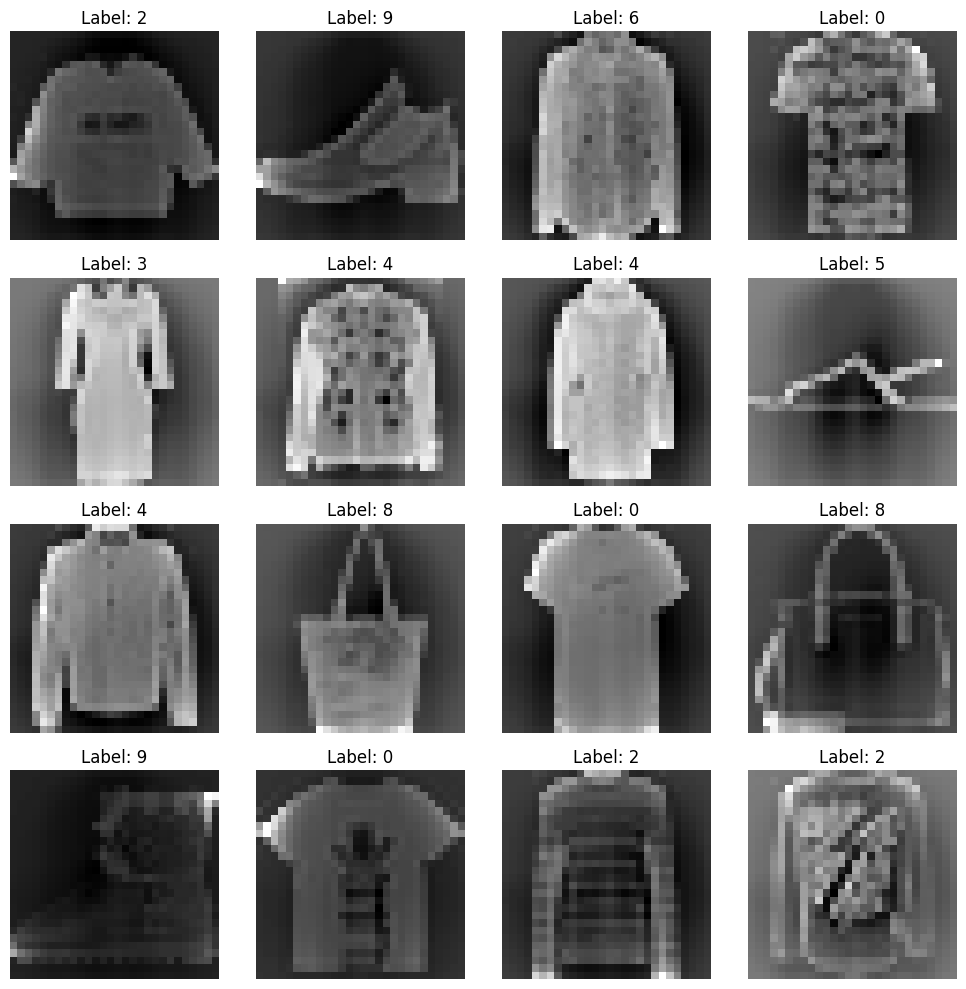

In [7]:
x_train_np = x_train.to_numpy()

num_images = 16
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    image_flattened = x_train_np[i]  
    image_reshaped = image_flattened.reshape(28, 28)  
    
    plt.imshow(image_reshaped, cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
x_train = x_train.T
x_test = x_test.T

In [9]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Stability improvement
    return expZ / np.sum(expZ, axis=0, keepdims=True)
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.max() + 1, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1]
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [10]:
def plot_training_progress(accuracy_list, loss_list):
    iterations = range(len(accuracy_list))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(iterations, accuracy_list, label="Accuracy", color='blue')
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy over Iterations")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(iterations, loss_list, label="Loss", color='red')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss over Iterations")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [11]:
def get_predictions(A2):
    return np.argmax(A2, axis = 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    return get_predictions(A2)


def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    accuracy_list = []
    loss_list = []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        predictions = get_predictions(A2)
        accuracy = get_accuracy(predictions, Y)
        loss = -np.mean(np.log(A2[Y, np.arange(Y.size)]))  # Cross-entropy loss

        accuracy_list.append(accuracy)
        loss_list.append(loss)

        if i % 100 == 0:
            print(f"Iteration {i}: Accuracy = {accuracy:.4f}, Loss = {loss:.4f}")

    plot_training_progress(accuracy_list, loss_list)
    return W1, b1, W2, b2


Iteration 0: Accuracy = 0.0785, Loss = 7.2424
Iteration 100: Accuracy = 0.6965, Loss = 0.8632
Iteration 200: Accuracy = 0.7368, Loss = 0.7533
Iteration 300: Accuracy = 0.7565, Loss = 0.6958
Iteration 400: Accuracy = 0.7705, Loss = 0.6534
Iteration 500: Accuracy = 0.7833, Loss = 0.6180
Iteration 600: Accuracy = 0.7948, Loss = 0.5907


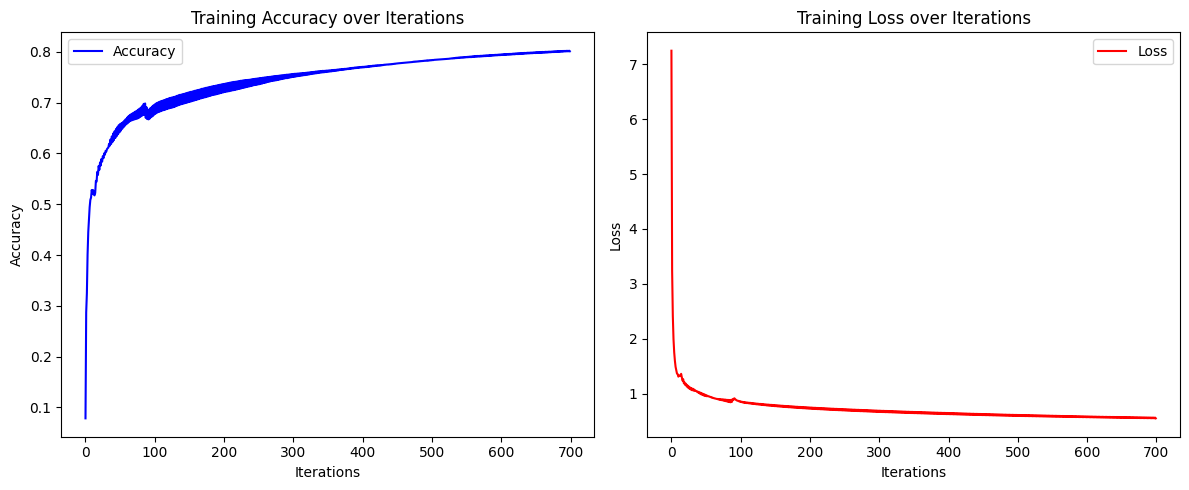

In [12]:
W1, b1, W2, b2 = gradient_descent(x_train, y_train, 0.2, 700)

In [13]:
dev_predictions = make_predictions(x_test, W1, b1, W2, b2)
get_accuracy(dev_predictions, y_test)

0.8013

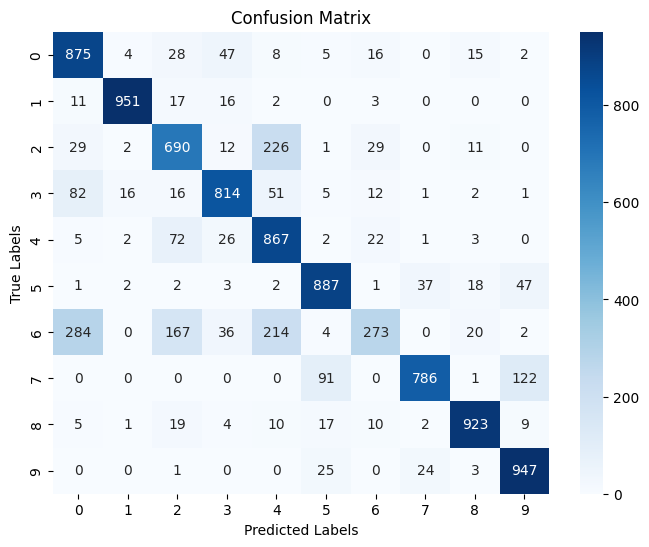

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_test, dev_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()